<h1>Машинне навчання</h1>
<p>Ю.С. Процик. Курс лекцій</p>
<div align="right"><em>Cформовано на основі <a href="https://mlcourse.ai">відкритого курсу</a> Юрія Кашницького</em></div>

# <center>Тема 11. Бустінг
    
## <center>Частина 1. Бустінг, градієнтний бустінг і Xgboost</center>

## План

1. [Загальна схема](#1.-Загальна-схема)
2. [Алгоритм AdaBoost](#2.-Алгоритм-AdaBoost)
3. [Градієнтний бустінг](#3.-Градієнтний-бустінг)
4. [Xgboost](#4.-Xgboost)
5. [Приклади використання](#5.-Приклади-використання)
6. [Корисні ресурси](#6.-Корисні-ресурси)

## 1. Загальна схема

Бустінг є жадібним алгоритмом побудови композиції алгоритмів. Основна ідея полягає в тому, щоб, маючи сукупність відносно слабких алгоритмів навчання, побудувати їх хорошу лінійну комбінацію. Він схожий на беггінг тим, що базовий алгоритм навчання є фіксованим. Відмінність полягає в тому, що навчання базових алгоритмів для композиції відбувається ітеративно, і кожен наступний алгоритм прагне компенсувати недоліки композиції всіх попередніх алгоритмів.

На прикладі бустінга стало зрозуміло, що хорошою якістю можуть володіти як завгодно складні композиції класифікаторів, за умови, що вони правильно налаштовуються. Це розвіяло уявлення, яке існувало довгий час, про те, що для підвищення узагальнюючої здатності необхідно обмежувати складність алгоритмів.

Згодом цей феномен бустінга отримав теоретичне обгрунтування. Виявилося, що зважене голосування не збільшує ефективну складність алгоритму, а лише згладжує відповіді базових алгоритмів. Ефективність бустінга пояснюється тим, що в міру додавання базових алгоритмів збільшуються відступи навчальних об'єктів. Причому бустінг продовжує розсувати класи навіть після досягнення безпомилкової класифікації навчальної вибірки.

Загальна схема бустінга:
- Шуканий ансамбль алгоритмів має вигляд 
$$
\large a(x) = \rm{sign}\left(\sum\limits_{t=1}^T \alpha_t b_t(x)\right),
$$
де $b_t$ – базові алгоритми.
- Ансамбль будується ітеративно, оптимізуючи на кожному кроці функціонал $Q_t$, що дорівнює кількості помилок поточної композиції на навчальній вибірці.
- При додаванні доданка $\alpha_t b_t(x)$ в суму, функціонал $Q_t$ оптимізується тільки по базовому алгоритму $b_t(x)$ і коефіцієнту $\alpha_t$ при ньому, всі попередні складові вважаються фіксованими.
- Функціонал $Q_t$ має вигляд суми по об'єктах навчальної вибірки порогових функцій виду $\large\left[y_i \sum\limits_{j=1}^t \alpha_j b_j(x_i) < 0\right]$, що мають зміст "поточна композиція помиляється на об'єкті з номером $i$". Кожен такий доданок має вигляд "сходинки" і є розривною функцією. Для спрощення розв'язання задачі оптимізації така порогова функція замінюється на неперервно диференційовну оцінку зверху. В результаті отримується новий функціонал $\hat{Q}_t \geqslant Q_t$, мінімізація якого призводить до мінімізації вихідного функціоналу $Q_t$.

Використовуючи різні апроксимації для порогової функції втрат $[z < 0]$, будемо отримувати різні види бустінга:
- $\large e^{-z}$ – AdaBoost;
- $\large \log_2(1 + e^{-z})$ – LogitBoost;
- $\large(1 - z)^2$ – GentleBoost;
- $\large e^{-cz(z+a)}$ – BrownBoost;
- інші.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina' 
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston

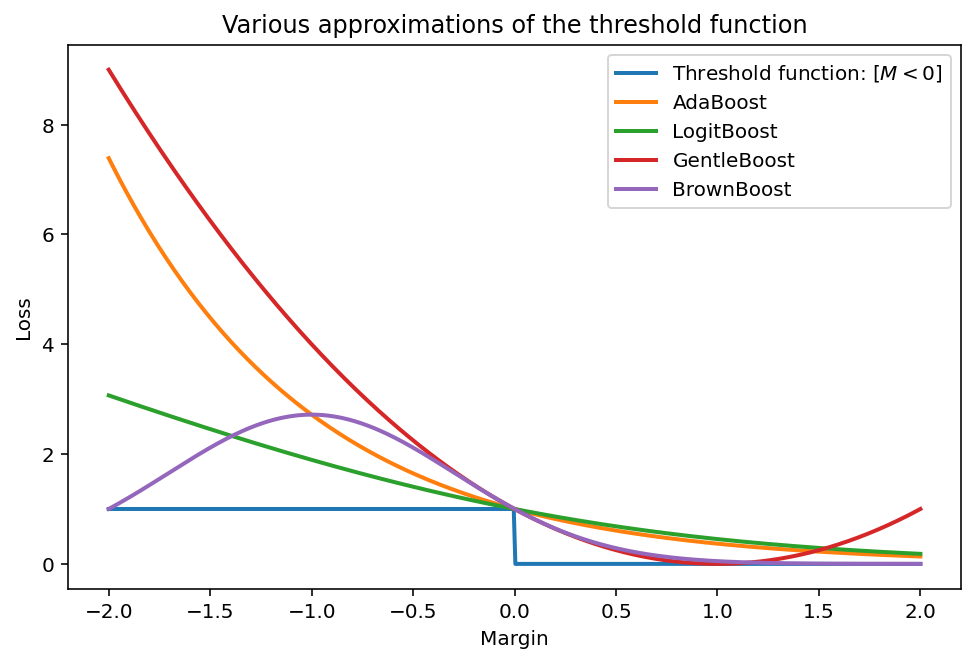

In [2]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(8,5))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[M < 0$]')
plt.plot(x, np.exp(-x), lw=2, label='AdaBoost')
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label='LogitBoost')
plt.plot(x, (1 - x) ** 2, lw=2, label='GentleBoost')
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label='BrownBoost')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best')
plt.xlabel('Margin')
plt.ylabel('Loss');

## 2. Алгоритм AdaBoost

Як було сказано, алгоритм AdaBoost отримується з описаної схеми, при апроксимації порогової функції втрат функцією $e^{-z}$. Існує теорема (Freund, Schapire, 1996), що дає для досить великих сімейств базових класифікаторів явні формули для базового алгоритму $b_t(x)$ і коефіцієнта $\alpha_t$ при ньому, на яких досягається мінімум функціоналу $\hat{Q}_t$.

Сам алгоритм виглядає наступним чином:
- Ініціалізувати ваги об'єктів $\large\displaystyle w_i^{(0)} = \frac{1}{\ell},\quad i = 1, \dots, \ell$.
- Для всіх $\large t = 1, \dots, T$
    * Навчити базовий алгоритм $\large b_t$, нехай $\large\epsilon_t$ – його помилка на навчальній вибірці.
    * $\large\displaystyle \alpha_t = \frac{1}{2}ln\frac{1 - \epsilon_t}{\epsilon_t}$.
    * Оновити ваги об'єктів: $\large w_i^{(t)} = w_i^{(t-1)} e^{-\alpha_t y_i b_t(x_i)},\quad i = 1, \dots, \ell$.
    * Нормувати ваги об'єктів: $\large\displaystyle w_0^{(t)} = \sum\limits_{j = 1}^k w_j^{(t)}, w_i^{(t)} = \frac{w_i^{(t)}}{w_0^{(t)}},\quad i = 1, \dots, \ell$.
- Повернути $\large\sum\limits_{t=1}^{T}\alpha_tb_t$.

Таким чином, алгоритм, що додається, навчається шляхом мінімізації зваженої частоти помилок на навчальній вибірці, а не стандартного функціоналу, рівного частоті помилок. Вага об'єкта збільшується в $e^{\alpha_t}$ раз, коли $b_t$ допускає на ньому помилку, і зменшується у стільки ж разів, коли $b_t$ правильно класифікує цей об'єкт. Таким чином, безпосередньо перед налаштуванням базового алгоритму найбільша вага накопичується у тих об'єктів, які частіше виявлялися важкими для класифікації попередніми алгоритмами.

### Приклад для ілюстрації
Нехай базові алгоритми – всього лише "пеньки", тобто дерева рішень глибини 1.
<img src='../img/adaboost_toy_step1.png' width=80%>
Ваги об'єктів, на яких базовий алгоритм помиляється, збільшуються (кружки збільшуються в розмірі).
<img src='../img/adaboost_toy_step2.png' width=50%>
В кінці базові алгоритми "голосують", їх ваги визначалися $\alpha_t$ в процесі побудови.
<img src='../img/adaboost_toy_step3.png' width=80%>

<img src="../img/boosting_overfitting.png">

Спочатку було виявлено відсутність перенавчання бустінга аж до 1000 базових класифікаторів, пізніше це було теоретично обгрунтовано.

## 3. Градієнтний бустінг

Метод градієнтного бустінга в деякому сенсі є узагальненням інших методів бустінга, оскільки він дозволяє оптимізувати довільну диференційовну функцію втрат. Даний алгоритм схожий на метод градієнтного спуску, що застосовується для розв'язання задач оптимізації. Основна ідея полягає в тому, що кожен наступний алгоритм, який додається в композицію налаштовується на залишки попередніх алгоритмів.

Нехай дана диференційовна функція втрат $\large L(F(x), y)$. Сам алгоритм виглядає наступним чином:
- Ініціалізація композиції константним значенням:
    $$\large\displaystyle F_0(x) = \arg\min\limits_{\gamma}\sum\limits_{i=1}^{\ell} L(\gamma, y_i).$$
- Для всіх $\large t = 1, \dots, T$:
    * Обчислити залишки попередньої композиції: 
    $$
    \large\displaystyle r_{it} = -\left[\frac{\partial L\left(F(x_i), y_i\right)}{\partial{F(x_i)}}\right]_{F(x) = F_{t-1}(x)},\quad i = 1, \dots, \ell.
    $$
    * Налаштувати базовий алгоритм $\large b_t(x)$ на отриманих залишках, тобто навчити його на вибірці $\large \{(x_i, r_{it}), i = 1, \dots, \ell\}$.
    * Обчислити коефіцієнт $\large\alpha_t$ перед базовим алгоритмом $\large b_t(x)$ як розв'язок наступної одновимірної задачі оптимізації:
    $$\large\displaystyle \alpha_t = \arg\min\limits_\alpha \sum\limits_{i=1}^{\ell} L(F_{t-1}(x_i) + \alpha b_t(x_i), y_i).$$
    * Додати отриманий доданок в композицію: 
    $$\large F_t(x) = F_{t-1}(x) + \alpha_t b_t(x).$$
    
Однією з можливих модифікацій даного алгоритму є стохастичний градієнтний бустінг (SGB), який полягає в тому, щоб обчислювати суми виду $\sum\limits_{i=1}^{\ell}$ не по всій навчальній вибірці, а тільки по деякій її випадковій підвибірці. Такий підхід є одним із способів регуляризації даного алгоритму і дозволяє поліпшити якість композиції, збіжність алгоритму і час навчання.

Інший спосіб регуляризації – це введення параметра $\gamma$, так званого темпу (швидкості) навчання. При додаванні нового доданка в композицію, будемо додавати його, помноженого на цей коефіцієнт. Як правило, чим менша швидкість навчання, тим краща якість кінцевої композиції.

Для задач регресії переважно використовують квадратичну функцію втрат $\large L(x, y) = (x - y)^2$ або модуль відхилення $\large L(x, y) = |x - y|$.
У задачі класифікації використовується логістична функція втрат, яка дозволяє повертати ймовірності приналежності об'єктів до класів.

Одним з найбільш популярних сімейств базових алгоритмів є дерева рішень. Саме такий варіант градієнтного бустінга <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">реалізовано</a> в sklearn.

## 4. Xgboost

XGBoost – поліпшення звичайного алгоритму градієнтного бустінга на деревах рішень через системну оптимізацію та удосконалення алгоритму.

Проблема багатьох алгоритмів побудови дерев в тому, що в них не приділяється належної уваги регуляризації.
У класичному градієнтному бустінгу застосовуються такі міри:
- обмеження на структуру дерева: максимальна глибина (`max_depth`), мінімальна кількість об'єктів в листку (`min_samples_leaf`);
- контроль швидкості навчання (`learning_rate`);
- збільшення "несхожості" дерев за рахунок рандомізації, як у випадковому лісі.

[Xgboost](https://github.com/dmlc/xgboost) використовує ще більше параметрів для регуляризації базових дерев.

Цільова функція для оптимізації в Xgboost складається з двох складових: специфічною функції втрат і регуляризатора $\Omega (f_k)$ для кожного з $K$ дерев, де $f_k$ – прогноз $k$-ого дерева.


$$\large
{\rm obj}(\theta) = \sum_{i=1}^{\ell} l(y_i,\hat{y_i}) +  \sum_{k=1}^{K} \Omega (f_k)
$$

Функція втрат залежить від розв'язуваної задачі (Xgboost адаптований під задачі класифікації, регресії і ранжування (детальніше добре описано в [документації](http://xgboost.readthedocs.io/) Xgboost), а регуляризатор виглядає наступним чином:
$$\large
\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2
$$

Перший доданок ($\gamma T$) штрафує модель за велику кількість листків $T$, а другий ($\displaystyle\frac{1}{2} \lambda \sum\limits_{j=1}^{T}w_j^2$) контролює суму ваг моделі в листках.

## 5. Приклади використання

У sklearn доступні алгоритми AdaBoost і GradientBoosting для задач класифікації і регресії.
Як приклад розглянемо розв'язання задачі відновлення одновимірної регресії за допомогою <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">GradientBoostingRegressor</a>.

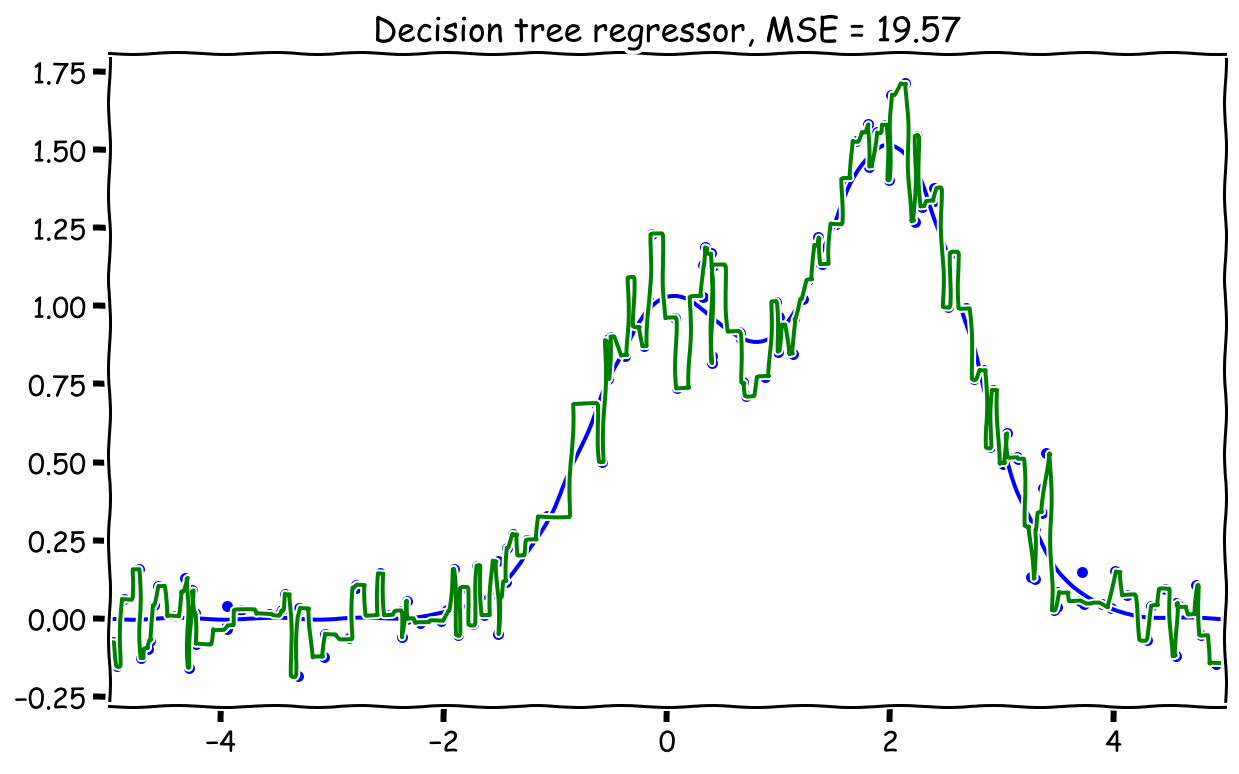

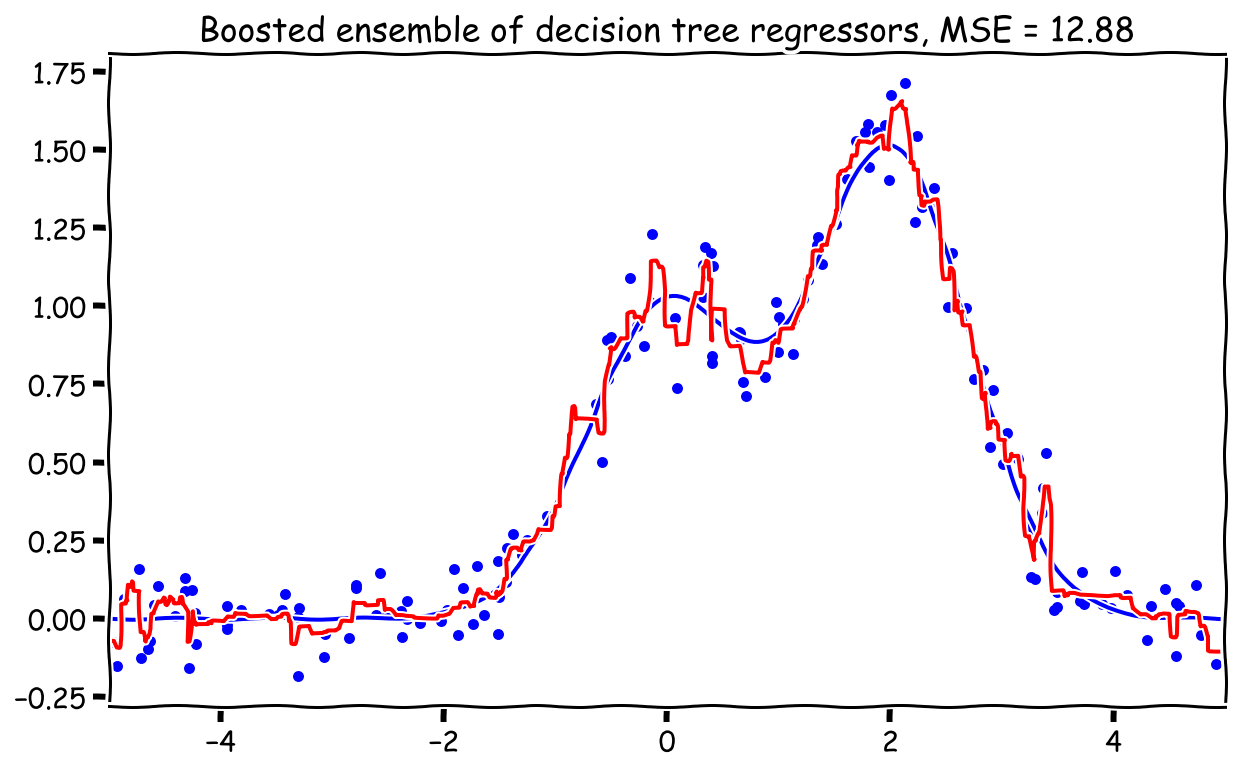

In [3]:
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) +\
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor(random_state=42)

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

with plt.xkcd():
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, d_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("Decision tree regressor, MSE = %.2f" % 
              np.sum((y_test - d_predict) ** 2))

    gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5,
                                      random_state=42)  
    gbtree.fit(X_train, y_train)
    gb_predict = gbtree.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, gb_predict, "r", lw=2)
    plt.xlim([-5, 5])
    plt.title("Boosted ensemble of decision tree regressors, MSE = %.2f" % 
              np.sum((y_test - gb_predict) ** 2));

Розглянемо приклад використання AdaBoostClassifier з деревами рішень одиничної глибини (decision stumps) в якості базових алгоритмів для розв'язання задачі класифікації.

In [4]:
data = pd.read_csv('../data/diabetes.csv', sep=',')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :8], 
                                                    data.iloc[:, 8], 
                                                    random_state=0)

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         random_state=42).fit(X_train, y_train)

print("Decision tree accuracy: %.2f" % dt.score(X_test, y_test))
print("AdaBoost accuracy: %.2f" % ada.score(X_test, y_test))

Decision tree accuracy: 0.71
AdaBoost accuracy: 0.79


**Приклад використання Xgboost для класифікації на даних Iris.**

In [6]:
iris = load_iris()
X = iris['data']
y = iris['target']
kf = KFold(n_splits=5, shuffle=True, random_state=13)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

[[ 9  0  0]
 [ 0  8  0]
 [ 0  1 12]]
[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
[[9 0 0]
 [0 9 1]
 [0 2 9]]
[[12  0  0]
 [ 0  9  2]
 [ 0  0  7]]
[[10  0  0]
 [ 0 11  0]
 [ 0  0  9]]


**Приклад відновлення регресії з Xgboost на даних boston.**

In [7]:
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

9.047410732647124
8.691280669876079
15.025941773762074
7.385308075054494
7.329729069724167


**Простий приклад підбору параметрів з GridSearchCV.**

In [8]:
X = boston['data']
y = boston['target']

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model, 
                        {'max_depth': [2,4,6]}, verbose=1)
xgb_grid.fit(X,y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6839859042772509
{'max_depth': 2}


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.8s finished


**Рання зупинка використовується для того, щоб припинити навчання моделі (градієнтний спуск), якщо помилка за декілька ітерацій не зменшилася.**

In [9]:
digits = load_digits()

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="merror",
        eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.14000
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.10667
[2]	validation_0-merror:0.08222
[3]	validation_0-merror:0.08000
[4]	validation_0-merror:0.06667
[5]	validation_0-merror:0.06444
[6]	validation_0-merror:0.07111
[7]	validation_0-merror:0.07111
[8]	validation_0-merror:0.06889
[9]	validation_0-merror:0.06667
[10]	validation_0-merror:0.06444
[11]	validation_0-merror:0.06667
[12]	validation_0-merror:0.06889
[13]	validation_0-merror:0.06000
[14]	validation_0-merror:0.05778
[15]	validation_0-merror:0.06222
[16]	validation_0-merror:0.06000
[17]	validation_0-merror:0.05778
[18]	validation_0-merror:0.05556
[19]	validation_0-merror:0.05333
[20]	validation_0-merror:0.05556
[21]	validation_0-merror:0.05556
[22]	validation_0-merror:0.04889
[23]	validation_0-merror:0.04889
[24]	validation_0-merror:0.05111
[25]	validation_0-merror:0.05333
[26]	validation_0-merror:0.05111
[27]	validation_0-merror:0.04889
[28]	validation_0-m

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

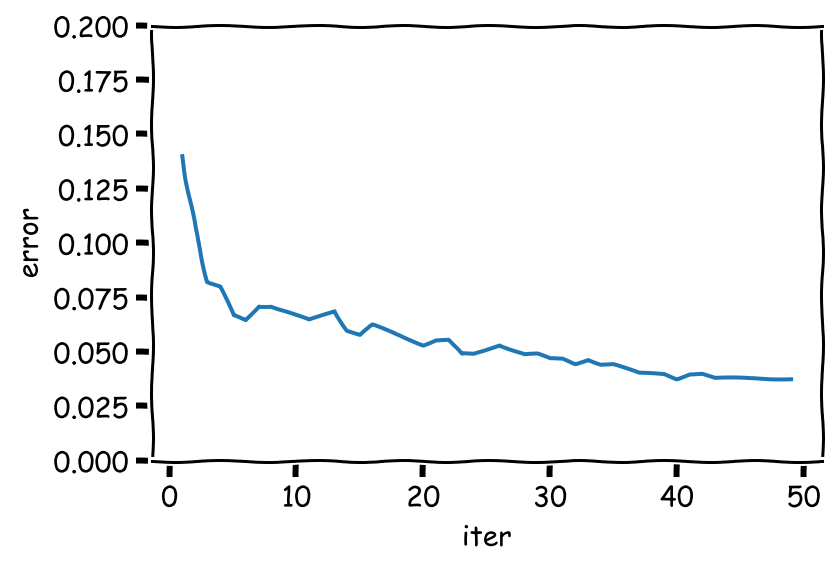

In [10]:
errors_by_iter = clf.evals_result()['validation_0']['merror']
with plt.xkcd():
    plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter)
    plt.xlabel('iter');
    plt.ylabel('error');
    plt.ylim(0, 0.2);

## 6. Корисні ресурси
- <a href="https://en.wikipedia.org/wiki/Boosting_(machine_learning)">Boosting</a>
- [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Лекція](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиційним методам класифікації
- <a href="https://github.com/dmlc/xgboost">Xgboost</a>
- <a href="https://github.com/ChenglongChen/Kaggle_CrowdFlower">Огляд</a> розв'язку (на основі Xgboost) переможця змагання Kaggle "CrowdFlower" з передбачення релевантності видачі пошуковика товарів.